# Figures

In [3]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using DelimitedFiles
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

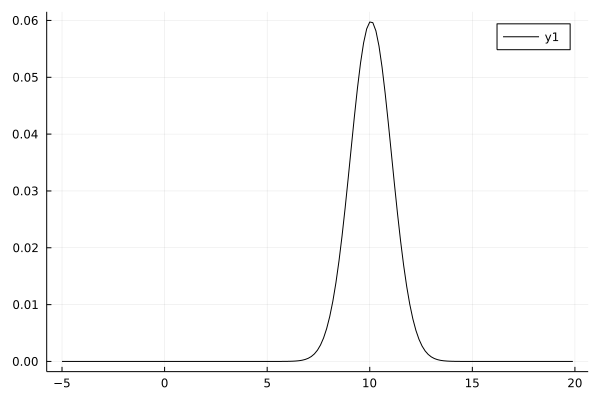

In [4]:

AgeTraitStructuredModels.reset_immigrants_RRS!(im,pop, 0.025, 0.01)
Plots.plot(im.grid,im.trait)

In [5]:
function equilibrium_RRS(population, immigrants, update!,before, prop_im, RRS,s)
    AgeTraitStructuredModels.reset!(population,s)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Estar, RRS)
    else
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Rstar, RRS)
    end
    return AgeTraitStructuredModels.equilibrium(population, update!, immigrants)
end 

function min_outcomes_RRS(population, immigrants, update!,before, T, prop_im, RRS,s)
    AgeTraitStructuredModels.reset!(population,s)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Estar, RRS)
    else
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Rstar, RRS)
    end
    return AgeTraitStructuredModels.min_outcomes(population, update!, immigrants, T)
end 

p_im = 0.1
RRS = 0.5
T = 10
min_outcomes_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, T, p_im, RRS,0.1)

(0.9521753210615147, 326.2044504658202, 0.04803963762319689, 0.9612329459954638)

In [76]:
using SharedArrays
p_im = (0.1:0.025:0.7).^2
RRS = 0.01:0.3:0.91
s = 0.1
Ws1 = zeros(length(p_im), length(RRS))
SSBs1 = zeros(length(p_im), length(RRS))

for i in 1:length(p_im) #Threads.@threads 
    print(i/length(p_im))
    print(" ")
    for j in 1:length(RRS)
        Ws1[i,j], SSBs1[i,j] = equilibrium_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, p_im[i], RRS[j],s)[1:2]
    end 
end 




writedlm( "data/Fitness_pimByRSS_s01.csv",  Ws1, ',')
writedlm( "data/Abundance_pimByRSS_s01.csv",  SSBs1, ',')

0.04 0.08 0.12 0.16 0.2 0.24 0.28 0.32 0.36 0.4 0.44 0.48 0.52 0.56 0.6 0.64 0.68 0.72 0.76 0.8 0.84 0.88 0.92 0.96 1.0 

In [41]:

s = 0.05
Ws2 = zeros(length(p_im), length(RRS))
SSBs2 = zeros(length(p_im), length(RRS))
for i in 1:length(p_im) #Threads.@threads 
    print(i/length(p_im))
    print(" ")
    for j in 1:length(RRS)
        Ws2[i,j], SSBs2[i,j] = equilibrium_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, p_im[i], RRS[j],s)[1:2]
    end 
end 
writedlm( "data/Fitness_pimByRSS_s005.csv",  Ws2, ',')
writedlm( "data/Abundance_pimByRSS_s005.csv",  SSBs2, ',')

0.05263157894736842 0.10526315789473684 0.15789473684210525 0.21052631578947367 0.2631578947368421 0.3157894736842105 0.3684210526315789 0.42105263157894735 0.47368421052631576 0.5263157894736842 0.5789473684210527 0.631578947368421 0.6842105263157895 0.7368421052631579 0.7894736842105263 0.8421052631578947 0.8947368421052632 0.9473684210526315 1.0 

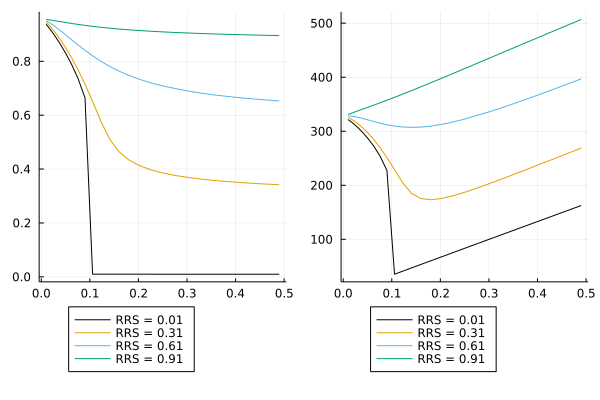

In [77]:
Ws1[18,3] = (Ws1[19,3] + Ws1[17,3])/2
SSBs1[18,3] = (SSBs1[19,3] + SSBs1[17,3])/2
p1 = Plots.plot(p_im, Ws1[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)
p2 = Plots.plot(p_im, SSBs1[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)

for i in 2:length(RRS)
    Plots.plot!(p1,p_im, Ws1[:,i], label = string("RRS = ",RRS[i] ))
    Plots.plot!(p2,p_im, SSBs1[:,i], label = string("RRS = ",RRS[i] ))

end
plot(p1,p2)

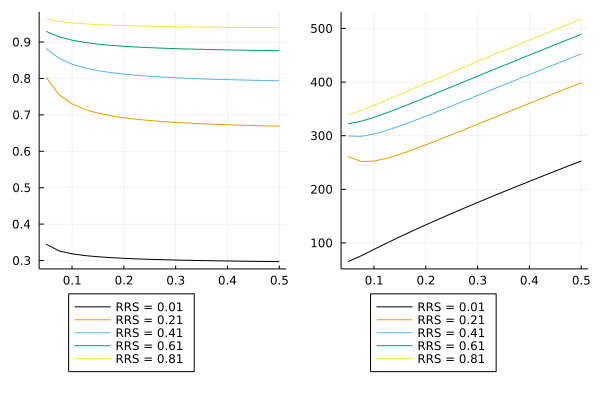

In [38]:
Ws2[16,2] = (Ws2[17,2] + Ws2[15,2])/2
SSBs2[16,2] = (SSBs2[17,2] + SSBs2[15,2])/2
p1 = Plots.plot(p_im, Ws2[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)
p2 = Plots.plot(p_im, SSBs2[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)

for i in 2:length(RRS)
    Plots.plot!(p1,p_im, Ws2[:,i], label = string("RRS = ",RRS[i] ))
    Plots.plot!(p2,p_im, SSBs2[:,i], label = string("RRS = ",RRS[i] ))

end
plot(p1,p2)

In [42]:
p_im = 0.25
RRS = 0.01:0.2:0.81

Tgen =  DemographicParameters.Smyth_2016_T1
T = Tgen.*2 .^(-2:0.5:6)

s = 0.1
Ws1 = zeros(length(T), length(RRS))
SSBs1 = zeros(length(T), length(RRS))

for i in 1:length(T)
    print(i/length(T))
    print(" ")
    for j in 1:length(RRS)
        Ws1[i,j], SSBs1[i,j] = min_outcomes_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, T[i], p_im, RRS[j],s)[1:2]
    end 
end 

writedlm( "data/Fitness_TimByRSS_s01_pim025.csv",  Ws1, ',')
writedlm( "data/Abundance_TimByRSS_s01_pim025.csv",  SSBs1, ',')

0.058823529411764705 0.11764705882352941 0.17647058823529413 0.23529411764705882 0.29411764705882354 0.35294117647058826 0.4117647058823529 0.47058823529411764 0.5294117647058824 0.5882352941176471 0.6470588235294118 0.7058823529411765 0.7647058823529411 0.8235294117647058 0.8823529411764706 0.9411764705882353 1.0 

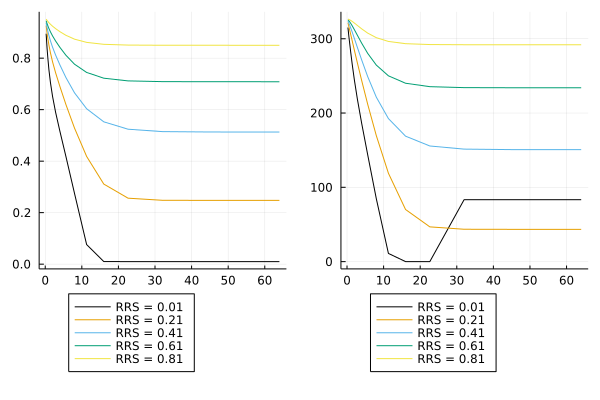

In [24]:
p1 = Plots.plot(T./Tgen, Ws1[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)
p2 = Plots.plot(T./Tgen, SSBs1[:,1], label = string("RRS = ",RRS[1] ),legend =:outerbottom)
for i in 2:length(RRS)
    Plots.plot!(p1,T./Tgen, Ws1[:,i], label = string("RRS = ",RRS[i] ))
    Plots.plot!(p2,T./Tgen, SSBs1[:,i], label = string("RRS = ",RRS[i] ))
end
plot(p1,p2)

In [67]:
p_im = 0.01:0.05:0.31
RRS = 0.25

Tgen =  DemographicParameters.Smyth_2016_T1
T = Tgen.*2 .^(-2:0.5:6)

s = 0.1
Ws1 = zeros(length(T), length(p_im ))
SSBs1 = zeros(length(T), length(p_im ))

for i in 1:length(T)
    print(i/length(T))
    print(" ")
    for j in 1:length(p_im)
        Ws1[i,j], SSBs1[i,j] = min_outcomes_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, T[i], p_im[j], RRS,s)[1:2]
    end 
end 

writedlm( "data/Fitness_TimByPim_RRS02.csv",  Ws1, ',')
writedlm( "data/Abundance_TimByPim_RRS0.csv",  SSBs1, ',')

0.058823529411764705 0.11764705882352941 0.17647058823529413 0.23529411764705882 0.29411764705882354 0.35294117647058826 0.4117647058823529 0.47058823529411764 0.5294117647058824 0.5882352941176471 0.6470588235294118 0.7058823529411765 0.7647058823529411 0.8235294117647058 0.8823529411764706 0.9411764705882353 1.0 

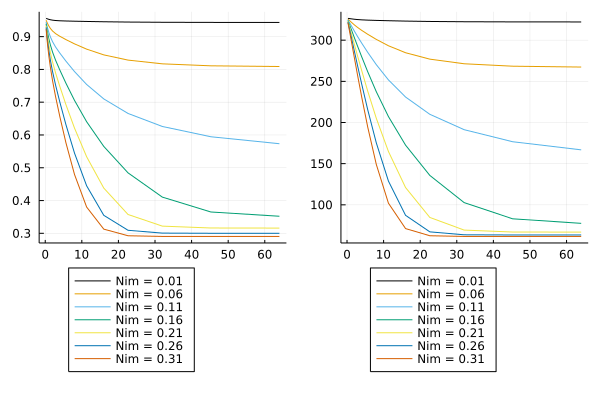

In [69]:
p1 = Plots.plot(T./Tgen, Ws1[:,1], label = string("Nim = ",p_im[1] ),legend =:outerbottom)
p2 = Plots.plot(T./Tgen, SSBs1[:,1], label = string("Nim = ",p_im[1] ),legend =:outerbottom)
for i in 2:length(p_im)
    Plots.plot!(p1,T./Tgen, Ws1[:,i], label = string("Nim = ",p_im[i] ))
    Plots.plot!(p2,T./Tgen, SSBs1[:,i], label = string("Nim = ",p_im[i] ))
end
plot(p1,p2)

In [56]:
p_im = 0.01:0.02:0.81
RRS = 0.1

Tgen =  DemographicParameters.Smyth_2016_T1
T = Tgen.*2 .^(-2:1.0:5)

s = 0.1
Ws1 = zeros(length(T), length(p_im))
SSBs1 = zeros(length(T), length(p_im))

for i in 1:length(T)
    print(i/length(T))
    print(" ")
    for j in 1:length(p_im)
        Ws1[i,j], SSBs1[i,j] = min_outcomes_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, T[i], p_im[j], RRS,s)[1:2]
    end 
end 

writedlm( "data/Fitness_TimByPim_s01_RSS01.csv",  Ws1, ',')
writedlm( "data/Abundance_TimByPim_s01_RSS01.csv",  SSBs1, ',')

0.125 0.25 0.375 0.5 0.625 0.75 0.875 1.0 

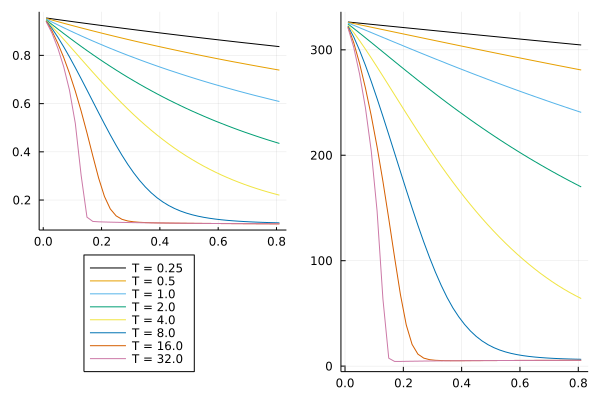

In [61]:
p1 = Plots.plot(p_im, Ws1[1,:], label = string("T = ",round(T[1]/Tgen,digits=2 )),legend =:outerbottom)
p2 = Plots.plot(p_im, SSBs1[1,:], label = string("T= ",round(T[1]/Tgen,digits=2)),legend =:none)
for i in 2:length(T)
    Plots.plot!(p1,p_im, Ws1[i,:], label = string("T = ",round(T[i]/Tgen,digits=2) ))
    Plots.plot!(p2,p_im, SSBs1[i,:], label = string("T = ",round(T[i]/Tgen,digits=2) ))
end
plot(p1,p2)

In [9]:
p_im = 0.01:0.1:2.0
RRS = 0.05

Tgen =  DemographicParameters.Smyth_2016_T1
T = Tgen.*2 .^(-2:1.0:5)

s = 0.1
Ws1 = zeros(length(T), length(p_im))
SSBs1 = zeros(length(T), length(p_im))

for i in 1:length(T)
    print(i/length(T))
    print(" ")
    for j in 1:length(p_im)
        Ws1[i,j], SSBs1[i,j] = min_outcomes_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, T[i], p_im[j], RRS,s)[1:2]
    end 
end 

writedlm( "data/Fitness_TimByPim_s01_RSS03.csv",  Ws1, ',')
writedlm( "data/Abundance_TimByPim_s01_RSS03.csv",  SSBs1, ',')

0.125 0.25 0.375 0.5 0.625 0.75 0.875 1.0 

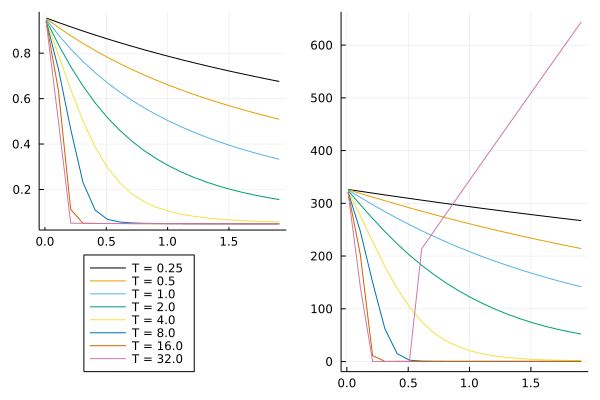

In [10]:
p1 = Plots.plot(p_im, Ws1[1,:], label = string("T = ",round(T[1]/Tgen,digits=2 )),legend =:outerbottom)
p2 = Plots.plot(p_im, SSBs1[1,:], label = string("T= ",round(T[1]/Tgen,digits=2)),legend =:none)
for i in 2:length(T)
    Plots.plot!(p1,p_im, Ws1[i,:], label = string("T = ",round(T[i]/Tgen,digits=2) ))
    Plots.plot!(p2,p_im, SSBs1[i,:], label = string("T = ",round(T[i]/Tgen,digits=2) ))
end
plot(p1,p2)

In [74]:
p_im = 0.0:0.05:0.55
RRS = collect(0.1:0.05:0.9).^2
s = 0.1
Ws1 = zeros(length(p_im), length(RRS))
SSBs1 = zeros(length(p_im), length(RRS))

for i in 1:length(p_im) #Threads.@threads 
    print(i/length(p_im))
    print(" ")
    for j in 1:length(RRS)
        Ws1[i,j], SSBs1[i,j] = equilibrium_RRS(pop, im, AgeTraitStructuredModels.time_step_DSI!, false, p_im[i], RRS[j],s)[1:2]
    end 
end 


using DelimitedFiles

writedlm( "data/Fitness_RSSByPim_s01.csv",  Ws1, ',')
writedlm( "data/Abundance_RSSByPim_s01.csv",  SSBs1, ',')

0.08333333333333333 0.16666666666666666 0.25 0.3333333333333333 0.4166666666666667 0.5 0.5833333333333334 0.6666666666666666 0.75 0.8333333333333334 0.9166666666666666 1.0 

In [75]:
p_im = 0.0:0.05:0.55
RRS = collect(0.1:0.05:0.9).^2
s = 0.1
Ws1 = zeros(length(p_im), length(RRS))
SSBs1 = zeros(length(p_im), length(RRS))

for i in 1:length(p_im) #Threads.@threads 
    print(i/length(p_im))
    print(" ")
    for j in 1:length(RRS)
        Ws1[i,j], SSBs1[i,j] = equilibrium_RRS(pop, im, AgeTraitStructuredModels.time_step_DIS!, false, p_im[i], RRS[j],s)[1:2]
    end 
end 


using DelimitedFiles

writedlm( "data/Fitness_RSSByPim_s01_DIS.csv",  Ws1, ',')
writedlm( "data/Abundance_RSSByPim_s01_DIS.csv",  SSBs1, ',')

0.08333333333333333 0.16666666666666666 0.25 0.3333333333333333 0.4166666666666667 0.5 0.5833333333333334 0.6666666666666666 0.75 0.8333333333333334 0.9166666666666666 1.0 